# First model: a single hidden layer

In [8]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from nolearn.lasagne import BatchIterator
import tensorflow as tf

## Loading data

Paths to datasets.

In [2]:
FROOT = os.getcwd() # Path to your project folder
FTRAIN = FROOT + '/data/training.csv'
FTEST = FROOT + '/data/test.csv'
FLOOKUP = FROOT + '/data/IdLookupTable.csv'

In [3]:
def load(test = False, cols = None):
    """
    Loads the dataset.
    
    Parameters
    ----------
    test  : optional, defaults to `False`
            Flag indicating if we need to load from `FTEST` (`True`) or `FTRAIN` (`False`)
    cols  : optional, defaults to `None`
            A list of columns you're interested in. If specified only returns these columns.
               
    Returns
    -------
    A tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [4]:
def plot_sample(x, y, axis):
    """
    Plots a single sample image with keypoints on top.
    
    Parameters
    ----------
    x     : 
            Image data.
    y     : 
            Keypoints to plot.
    axis  :
            Plot over which to draw the sample.   
    """
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

Load the training dataset.

In [5]:
X, y = load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

Verify that data is ok by querying and plotting an arbitrary image.

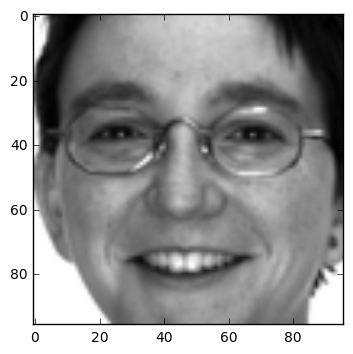

In [9]:
img = X[11].reshape(96, 96)
pyplot.imshow(img, cmap='gray')
pyplot.show()

Split the initial training dataset into training, validation and testing datasets.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

## Parameters

In [11]:
# Predefined parameters
image_size = 96
num_keypoints = 30
batch_size = 36
num_epochs = 1001
learning_rate = 0.01
momentum = 0.9

model_name = "1fc_b" + str(batch_size) + "_e" + str(num_epochs - 1)
model_variable_scope = model_name
root_location = FROOT + "/models/"
model_path = root_location + model_name + "/model.ckpt"
train_history_path = root_location + model_name + "/train_history"

os.makedirs(root_location + model_name + "/", exist_ok = True)

## Routines

Performs a single fully connected layer pass, e.g. returns `input * weights + bias`:

In [12]:
def fully_connected(input, size):
    """
    Creates a fully connected TensorFlow layer.
    
    Parameters
    ----------
    input  : 
            Input tensor for calculating layer shape.
    size   : 
            Layer size, e.g. number of units.
               
    Returns
    -------
    A graph variable calculating single fully connected layer.
    """
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer=tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

Performs entire model pass, e.g. returns model prediction for given input with current model (single hidden fully connected layer):

In [13]:
def model_pass(input):
    """
    Performs a whole model pass.
    
    Parameters
    ----------
    input : 
            Input tensor to be passed through the model.
               
    Returns
    -------
    Model prediction.
    """
    with tf.variable_scope('hidden'):
        hidden = fully_connected(input, size = 100)
    relu_hidden = tf.nn.relu(hidden)
    with tf.variable_scope('out'):
        prediction = fully_connected(relu_hidden, size = num_keypoints)
    return prediction

Calculates loss based on model predictions.

In [14]:
def calc_loss(predictions, labels):
    """
    Calculates loss with NumPy.
    
    Parameters
    ----------
    predictions : ndarray 
                  Predictions.
    labels      : ndarray
                  Actual values.
               
    Returns
    -------
    Squared mean error for given predictions.
    """
    return np.mean(np.square(predictions - labels))

Calculates time since `start` and formats as a string.

In [15]:
def get_time_hhmmss(start):
    """
    Calculates time since `start` and formats as a string.
    
    Parameters
    ----------
    start :  
            Time starting point.
               
    Returns
    -------
    Nicely formatted time difference between now and `start`.
    """
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

## Training

In [16]:
graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size * image_size))
    tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))

    # Training computation.
    with tf.variable_scope(model_variable_scope):
        predictions = model_pass(tf_x_batch)
    
    loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))

    # Optimizer.
    optimizer = tf.train.MomentumOptimizer(
        learning_rate = learning_rate, 
        momentum = momentum, 
        use_nesterov = True
    ).minimize(loss)

In [17]:
def get_predictions_in_batches(X, session):
    """
    Calculates predictions in batches of 128 examples at a time, using `session`'s calculation graph.
    
    Parameters
    ----------
    X       : ndarray
              Dataset to get predictions for.
    session :
              TensorFlow session to be used for predicting. Is expected to have a `predictions` var 
              in the graph along with a `tf_x_batch` placeholder for incoming data.
               
    Returns
    -------
    N-dimensional array of predictions.
    """
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, _ in batch_iterator(X):
        [p_batch] = session.run([predictions], feed_dict = {
                tf_x_batch : x_batch 
            }
        )
        p.extend(p_batch)
    return p

In [18]:
start = time.time()
every_epoch_to_log = 5

with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    train_loss_history = np.zeros(num_epochs)
    valid_loss_history = np.zeros(num_epochs)
    print("============ TRAINING =============")
    for epoch in range(num_epochs):
        # Train on whole randomised dataset in batches
        batch_iterator = BatchIterator(batch_size = batch_size, shuffle = True)
        for x_batch, y_batch in batch_iterator(x_train, y_train):
            session.run([optimizer], feed_dict = {
                    tf_x_batch : x_batch, 
                    tf_y_batch : y_batch
                }
            )

        # If another significant epoch ended, we log our losses.
        if (epoch % every_epoch_to_log == 0):
            # Get training data predictions and log training loss:
            train_loss = calc_loss(
                get_predictions_in_batches(x_train, session), 
                y_train
            )
            train_loss_history[epoch] = train_loss

            # Get validation data predictions and log validation loss:
            valid_loss = calc_loss(
                get_predictions_in_batches(x_valid, session), 
                y_valid
            )
            valid_loss_history[epoch] = valid_loss
            
            if (epoch % 100 == 0):
                print("--------- EPOCH %4d/%d ---------" % (epoch, num_epochs))
                print("     Train loss: %.8f" % (train_loss))
                print("Validation loss: %.8f" % (valid_loss))
                print("           Time: " + get_time_hhmmss(start))

    # Evaluate on test dataset.
    test_loss = calc_loss(
        get_predictions_in_batches(x_test, session), 
        y_test
    )
    print("===================================")
    print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
    print(" Total time: " + get_time_hhmmss(start))
    
    # Save model weights for future use.
    save_path = saver.save(session, model_path)
    print("Model file: " + save_path)
    np.savez(train_history_path, train_loss_history = train_loss_history, valid_loss_history = valid_loss_history)
    print("Train history file: " + train_history_path)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
============ TRAINING =============
--------- EPOCH    0/1001 ---------
     Train loss: 0.01383171
Validation loss: 0.01376384
           Time: 00:00:01
--------- EPOCH  100/1001 ---------
     Train loss: 0.00287254
Validation loss: 0.00430489
           Time: 00:00:15
--------- EPOCH  200/1001 ---------
     Train loss: 0.00238277
Validation loss: 0.00392728
           Time: 00:00:28
--------- EPOCH  300/1001 ---------
     Train loss: 0.00158785
Validation loss: 0.00318821
           Time: 00:00:42
--------- EPOCH  400/1001 ---------
     Train loss: 0.00141799
Validation loss: 0.00310088
           Time: 00:00:55
--------- EPOCH  500/1001 ---------
     Train loss: 0.00124548
Validation loss: 0.00302810
           Time: 00:01:09
--------- EPOCH  600/1001 ---------
     Train loss: 0.00119287
Validation loss: 0.00302953
           Time: 00:01:22
--------- EPOCH  700/1001 ---------
     Train loss: 0.00103531


## Evaluation

In [19]:
# Plots history of learning curves for a specific model. You may want to call `pyplot.show()` afterwards.
def plot_learning_curves(model = model_name, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    """
    Plots history of learning curves for a specific model based on the saved training history. 
    You may want to call `pyplot.show()` afterwards.
    
    Parameters
    ----------
    model             : optional, defaults to current model name
                        Model name.
    linewidth         : optional, defaults to 2
                        Line thickness.
    train_linestyle   : optional, defaults to "b-"
                        Matplotlib line style for the training curve.
    valid_linestyle   : optional, defaults to "g-"
                        Matplotlib line style for the validation curve.
               
    Returns
    -------
    Number of epochs plotted.
    """
    model_history = np.load(root_location + model + "/train_history.npz")
    train_loss = model_history["train_loss_history"]
    valid_loss = model_history["valid_loss_history"]
    epochs = train_loss.shape[0]
    x_axis = np.arange(epochs)
    pyplot.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], train_linestyle, linewidth=linewidth, label=model + " train")
    pyplot.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], valid_linestyle, linewidth=linewidth, label=model + " valid")
    return epochs

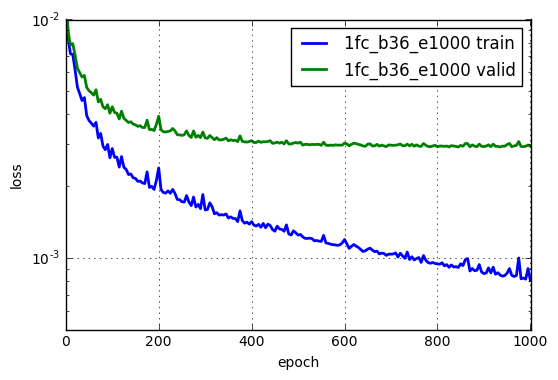

In [20]:
new_model_epochs = plot_learning_curves()

pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.0005, 0.01)
pyplot.xlim(0, new_model_epochs)
pyplot.yscale("log")
pyplot.show()

Now, let's take a look at the data and predictions. 

Load training data, restore saved model parameters and get predictions:

In [21]:
X, _ = load(test = True)

with graph.as_default():
    tf_x = tf.constant(X)

    with tf.variable_scope(model_variable_scope, reuse = True):
        tf_p = model_pass(tf_x)  
        
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    load_path = saver.restore(session, model_path)
    p = tf_p.eval()

ImageId    1783
Image      1783
dtype: int64
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Display some of the dataset images and our model's predictions:

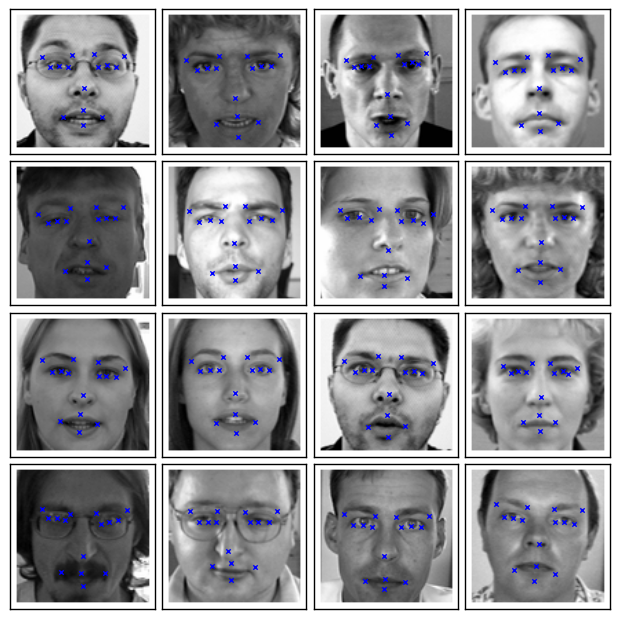

In [22]:
fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], p[i], ax)

pyplot.show()